# Assignmant
Lab04-2 110065508 李丞恩

You have to implement:
1. a Linear(Polynomial) regressor
2. a Random Forest regressor
3. You need to show a residual plot for each of your model on both training data and testing data.
4. $R^2$ score need to be larger than 0.72 on testing data.

In [1]:
# inline plotting instead of popping out
%matplotlib inline

from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Preparing the dataset
load the dataset

In [2]:
df = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv',
    sep=',')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


清資料，這塊不要動。

In [3]:
# Do not modify
df = df.drop(['cbwd'], axis=1)  # drop non-scalar feature
df = df.dropna(axis=0, how='any')  # drop samples who has nan feature
idx = np.logical_or(
    np.logical_and(df['year'].values == 2014, df['month'].values < 3),
    np.logical_and(df['year'].values == 2013, df['month'].values == 12))
X = df.loc[idx].drop('pm2.5', axis=1)
y = df.loc[idx]['pm2.5'].values
X.head()

,No,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir
34320,34321,2013,12,1,0,-13,-2.0,1026.0,0.89,0,0
34321,34322,2013,12,1,1,-14,-3.0,1025.0,3.13,0,0
34322,34323,2013,12,1,2,-13,-3.0,1025.0,0.89,0,0
34323,34324,2013,12,1,3,-13,-4.0,1025.0,0.89,0,0
34324,34325,2013,12,1,4,-13,-3.0,1025.0,1.78,0,0


雖然看起來很蠢，但姑且還是畫一下所有變數對pm2.5的散佈圖。

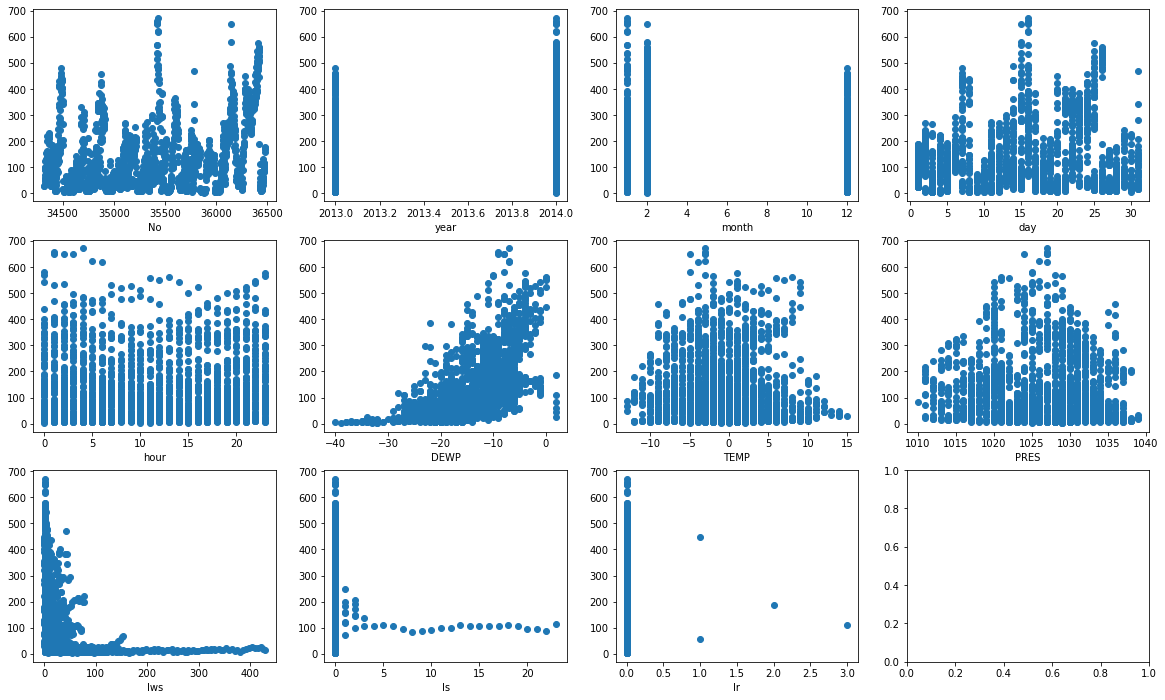

In [4]:
x_vars = ['No', 'year', 'month', 'day', 'hour', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']

_, subplot_arr = plt.subplots(3, 4, figsize=(20, 12))
for idx, x_var in enumerate(x_vars):
    x_idx = idx // 4
    y_idx = idx % 4
    subplot_arr[x_idx, y_idx].scatter(X[x_var], y)
    subplot_arr[x_idx, y_idx].set_xlabel(x_var)

plt.show()

可發現與PM2.5的值最相關的是DEWP或Iws。開始拆training和testing set。經過不斷的實驗，我發現將DEWP作為$y$軸(PM2.5)取log，最能呈現出線性相關。接著進行train/test split以及標準化。

In [5]:
X_DEWP = X['DEWP'].values[:, np.newaxis] # Iws or DEWP
#X_DEWP = np.interp(X_DEWP, (X_DEWP.min(), X_DEWP.max()), (0, X_DEWP.max()-X_DEWP.min()))
#X_DEWP = np.sqrt(X_DEWP) 
y_DEWP = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X_DEWP, y_DEWP, test_size=0.3, random_state=1)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])

# Standardization
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
y_train_std = sc.fit_transform(y_train[:, np.newaxis]).flatten()
y_test_std = sc.fit_transform(y_test[:, np.newaxis]).flatten()

#Training data points: 1491
#Testing data points: 639


## Linear Regression

In [6]:
class LinearRegressionGD(object):
    def __init__(self, eta=0.001, n_iter=20, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            
            # Cost function
            error = (y - output)
            cost = (error**2).sum() / 2.0
            self.cost_.append(cost)
            
            # Update rule
            self.w_[1:] += self.eta * X.T.dot(error)
            self.w_[0] += self.eta * error.sum()
            
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

因為線性回歸是convex optimize，無論參數怎麼調，只要收斂都一定是收斂到全局最優解，因此實驗一下，選剛好的參數來訓練就好了。

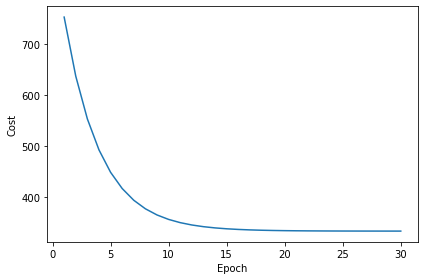

In [7]:
lr = LinearRegressionGD(eta=1e-4, n_iter=30)
lr.fit(X_train_std, y_train_std) # 可拿掉std

plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

Testing & $R^2$ value。$R^2$最好只能做到0.50。不知道是怎麼做到0.72的......

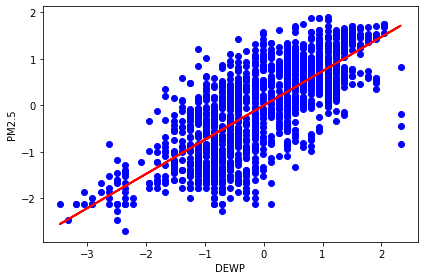

In [8]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)
    return

lin_regplot(X_train_std, y_train_std, lr) # 可拿掉std
plt.xlabel('DEWP')
plt.ylabel('PM2.5')
plt.tight_layout()
plt.show()

In [9]:
# Testing
y_train_pred = lr.predict(X_train_std) # 可拿掉std
y_test_pred = lr.predict(X_test_std) # 可拿掉std

print('MSE train: %.2f, test: %.2f' % (mean_squared_error(y_train_std, y_train_pred), # 可拿掉std
                                       mean_squared_error(y_test_std, y_test_pred))) # 可拿掉std
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train_std, y_train_pred), # 可拿掉std
                                       r2_score(y_test_std, y_test_pred))) # 可拿掉std

MSE train: 0.45, test: 0.50
R^2 train: 0.55, test: 0.50


Residual Plot

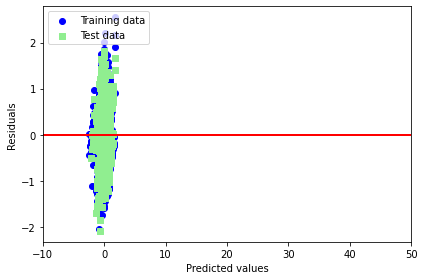

In [10]:
plt.scatter(
    y_train_pred,
    y_train_pred - y_train_std, # 可拿掉std
    c='blue',
    marker='o',
    label='Training data')
plt.scatter(
    y_test_pred,
    y_test_pred - y_test_std, # 可拿掉std
    c='lightgreen',
    marker='s',
    label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

此外，用高次多項式去回歸，也不見得好到哪裡去。

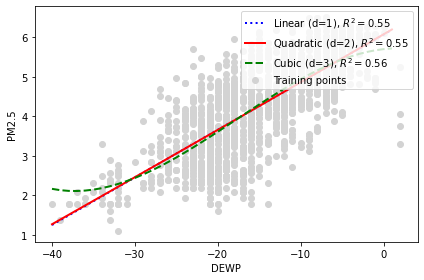

In [11]:
# Create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X_train)
X_cubic = cubic.fit_transform(X_train)

# Fit features
lin_regr = LinearRegression()
lin_regr.fit(X_train, y_train)
linear_r2 = r2_score(y_train, lin_regr.predict(X_train))

quad_regr = LinearRegression()
quad_regr.fit(X_quad, y_train)
quadratic_r2 = r2_score(y_train, quad_regr.predict(X_quad))

cubic_regr = LinearRegression()
cubic_regr.fit(X_cubic, y_train)
cubic_r2 = r2_score(y_train, cubic_regr.predict(X_cubic))

# Plot results
X_range = np.arange(X_train.min(), X_train.max(), 1)[:, np.newaxis]
y_train_pred = lin_regr.predict(X_range)
y_quad_pred = quad_regr.predict(quadratic.fit_transform(X_range))
y_cubic_pred = cubic_regr.predict(cubic.fit_transform(X_range))

plt.scatter(X_train, y_train, label='Training points', color='lightgray')

plt.plot(
    X_range,
    y_train_pred,
    label='Linear (d=1), $R^2=%.2f$' % linear_r2,
    color='blue',
    lw=2,
    linestyle=':')

plt.plot(
    X_range,
    y_quad_pred,
    label='Quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
    color='red',
    lw=2,
    linestyle='-')

plt.plot(
    X_range,
    y_cubic_pred,
    label='Cubic (d=3), $R^2=%.2f$' % cubic_r2,
    color='green',
    lw=2,
    linestyle='--')

plt.xlabel('DEWP')
plt.ylabel('PM2.5')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Random Forest regressor

training the regressor

In [12]:
forest = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

Testing & $R^2$ value

In [13]:
print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

MSE train: 0.57, test: 0.64
R^2 train: 0.59, test: 0.54


Residual plot

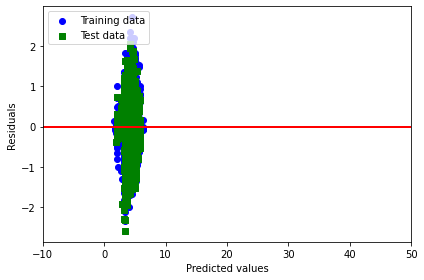

In [14]:
# Residual plot
plt.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='blue',
    marker='o',
    label='Training data')
plt.scatter(
    y_test_pred, y_test_pred - y_test, c='green', marker='s', label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()